In [71]:
# !pip install scipy
# !pip install seaborn
# !pip install matplotlib
# !pip install spacy

     ---------------------------------------- 0.0/45.9 kB ? eta -:--:--
     ---------------------------------------- 45.9/45.9 kB ? eta 0:00:00
     ---------------------------------------- 0.0/181.6 kB ? eta -:--:--
     ------------------------------------- 181.6/181.6 kB 10.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/12.1 MB ? eta -:--:--
   --- ------------------------------------ 1.0/12.1 MB 20.5 MB/s eta 0:00:01
   ------ --------------------------------- 2.1/12.1 MB 22.3 MB/s eta 0:00:01
   --------------- ------------------------ 4.7/12.1 MB 37.5 MB/s eta 0:00:01
   ---------------------- ----------------- 6.7/12.1 MB 38.8 MB/s eta 0:00:01
   ----------------------- ---------------- 7.2/12.1 MB 38.4 MB/s eta 0:00:01
   ------------------------ --------------- 7.3/12.1 MB 27.3 MB/s eta 0:00:01
   ---------------------------------------  12.1/12.1 MB 43.5 MB/s eta 0:00:01
   ---------------------------------------- 12.1/12.1 MB 38.4 MB/s eta 0:00:00
   ---

In [6]:
import numpy as np
from numpy.linalg import norm

from llama_cpp.llama import Llama, LlamaGrammar
from langchain.embeddings import LlamaCppEmbeddings

import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# load input/educations.csv into pandas
df = pd.read_csv("input/educations.csv")
df.head()

,EducationTitle,Description,Duration,SkillsAcquired,Level
0,Spanish Language Essentials,Immerse yourself in the basics of Spanish lang...,6 weeks,Spanish Vocabulary;Grammar;Conversational Skills,Beginner
1,Photography Fundamentals,"Learn the art of photography, including camera...",8 weeks,Camera Settings;Composition;Photo Editing,Intermediate
2,Healthy Cooking for Beginners,"Discover the fundamentals of healthy cooking, ...",10 weeks,Meal Planning;Nutrition Basics;Cooking Skills,Beginner
3,Introduction to Astronomy,"Explore the wonders of the universe, covering ...",12 weeks,Astronomy Basics;Stargazing Techniques;Celesti...,Beginner
4,Introduction to Sustainable Living,"Gain insights into sustainable practices, incl...",8 weeks,Sustainable Living Practices;Environmental Awa...,Beginner


In [7]:
filename = "mistral-7b-v0.1.Q4_K_M.gguf"

llm = LlamaCppEmbeddings(model_path=filename)

AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 0 | SSE3 = 1 | SSSE3 = 0 | VSX = 0 | 


In [8]:
def embed_row_0(i, df):
    input = f"""{df['EducationTitle'][i]} {df['SkillsAcquired'][i]}""".replace(";", " ")
    print(f"Index {i} - {len(df)}: {input}")
    return llm.embed_query(input)

def embed_row_1(i, df):
    input = f"""{df['SkillsAcquired'][i]}""".replace(";", " ")
    print(f"Index {i} - {len(df)}: {input}")
    return llm.embed_query(input)

def embed_row_2(i, df):
    input = f"""
    Education Title: {df['EducationTitle'][i]}
    Description: {df['Description'][i]}
    Skills Acquired: {df['SkillsAcquired'][i]}
    Level: {df['Level'][i]}
    """.replace(";", " ")
    print(f"Index {i} - {len(df)}: {input}")
    return llm.embed_query(input)

In [9]:
def generate_embeddings_with_checkpoints(df, embed_function, checkpoint_interval=10, checkpoint_path="embeddings_checkpoint.pkl"):
    embeddings = []
    checkpoint_index = 0

    # randomise the dataframe rows
    df = df.sample(frac=1).reset_index(drop=True)

    # Attempt to load from checkpoint if exists
    try:
        with open(checkpoint_path, 'rb') as file:
            embeddings, checkpoint_index = pickle.load(file)
            print(f"Resuming from checkpoint at index {checkpoint_index}")
    except FileNotFoundError:
        print("No checkpoint found, starting from scratch")

    # Adjust the loop to iterate over DataFrame rows
    for i in df.index[checkpoint_index:]:
        # Assuming embed_row correctly handles DataFrame rows
        embeddings.append(embed_function(i, df))

        # Save a checkpoint every 'checkpoint_interval' iterations
        if (len(embeddings) % checkpoint_interval == 0) or (i == df.index[-1]):
            with open(checkpoint_path, 'wb') as file:
                pickle.dump((embeddings, i + 1), file)
                print(f"Checkpoint saved at index {i + 1}")

    return embeddings

In [10]:
# embeddings_0 = generate_embeddings_with_checkpoints(df, embed_row_0, checkpoint_interval=10, checkpoint_path="embeddings_checkpoint_title_skills.pkl")
embeddings_1 = generate_embeddings_with_checkpoints(df, embed_row_1, checkpoint_interval=10, checkpoint_path="embeddings_checkpoint_skills.pkl")
# embeddings_2 = generate_embeddings_with_checkpoints(df, embed_row_2, checkpoint_interval=10, checkpoint_path="embeddings_checkpoint_full.pkl")

No checkpoint found, starting from scratch
Index 0 - 308: Spanish Vocabulary Grammar Conversational Skills
Index 1 - 308: Camera Settings Composition Photo Editing
Index 2 - 308: Meal Planning Nutrition Basics Cooking Skills
Index 3 - 308: Astronomy Basics Stargazing Techniques Celestial Navigation
Index 4 - 308: Sustainable Living Practices Environmental Awareness Green Energy
Index 5 - 308: Graphic Design Principles Adobe Creative Cloud Design Software
Index 6 - 308: Mindfulness Meditation Techniques Stress Management Relaxation Skills
Index 7 - 308: Plant Care Techniques Garden Design Home Vegetable Cultivation
Index 8 - 308: Personal Budgeting Investment Basics Credit Management
Index 9 - 308: Programming Logic Scratch Coding Algorithmic Thinking
Checkpoint saved at index 10
Index 10 - 308: Creative Writing Techniques Storytelling Genre Exploration
Index 11 - 308: Strength Training Techniques Personalized Fitness Planning Nutrition for Fitness
Index 12 - 308: Python Programming Fun

In [11]:
embeddings = embeddings_1

In [12]:
def compare_embeddings(embeddings):
    n = len(embeddings)
    similarity_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(i, n):
            similarity = np.dot(embeddings[i],embeddings[j])/(norm(embeddings[i])*norm(embeddings[j]))
            similarity_matrix[i][j] = similarity
            similarity_matrix[j][i] = similarity  # The matrix is symmetric

    return similarity_matrix

# Assuming 'embeddings' is your list of embeddings
similarity_matrix = compare_embeddings(embeddings)


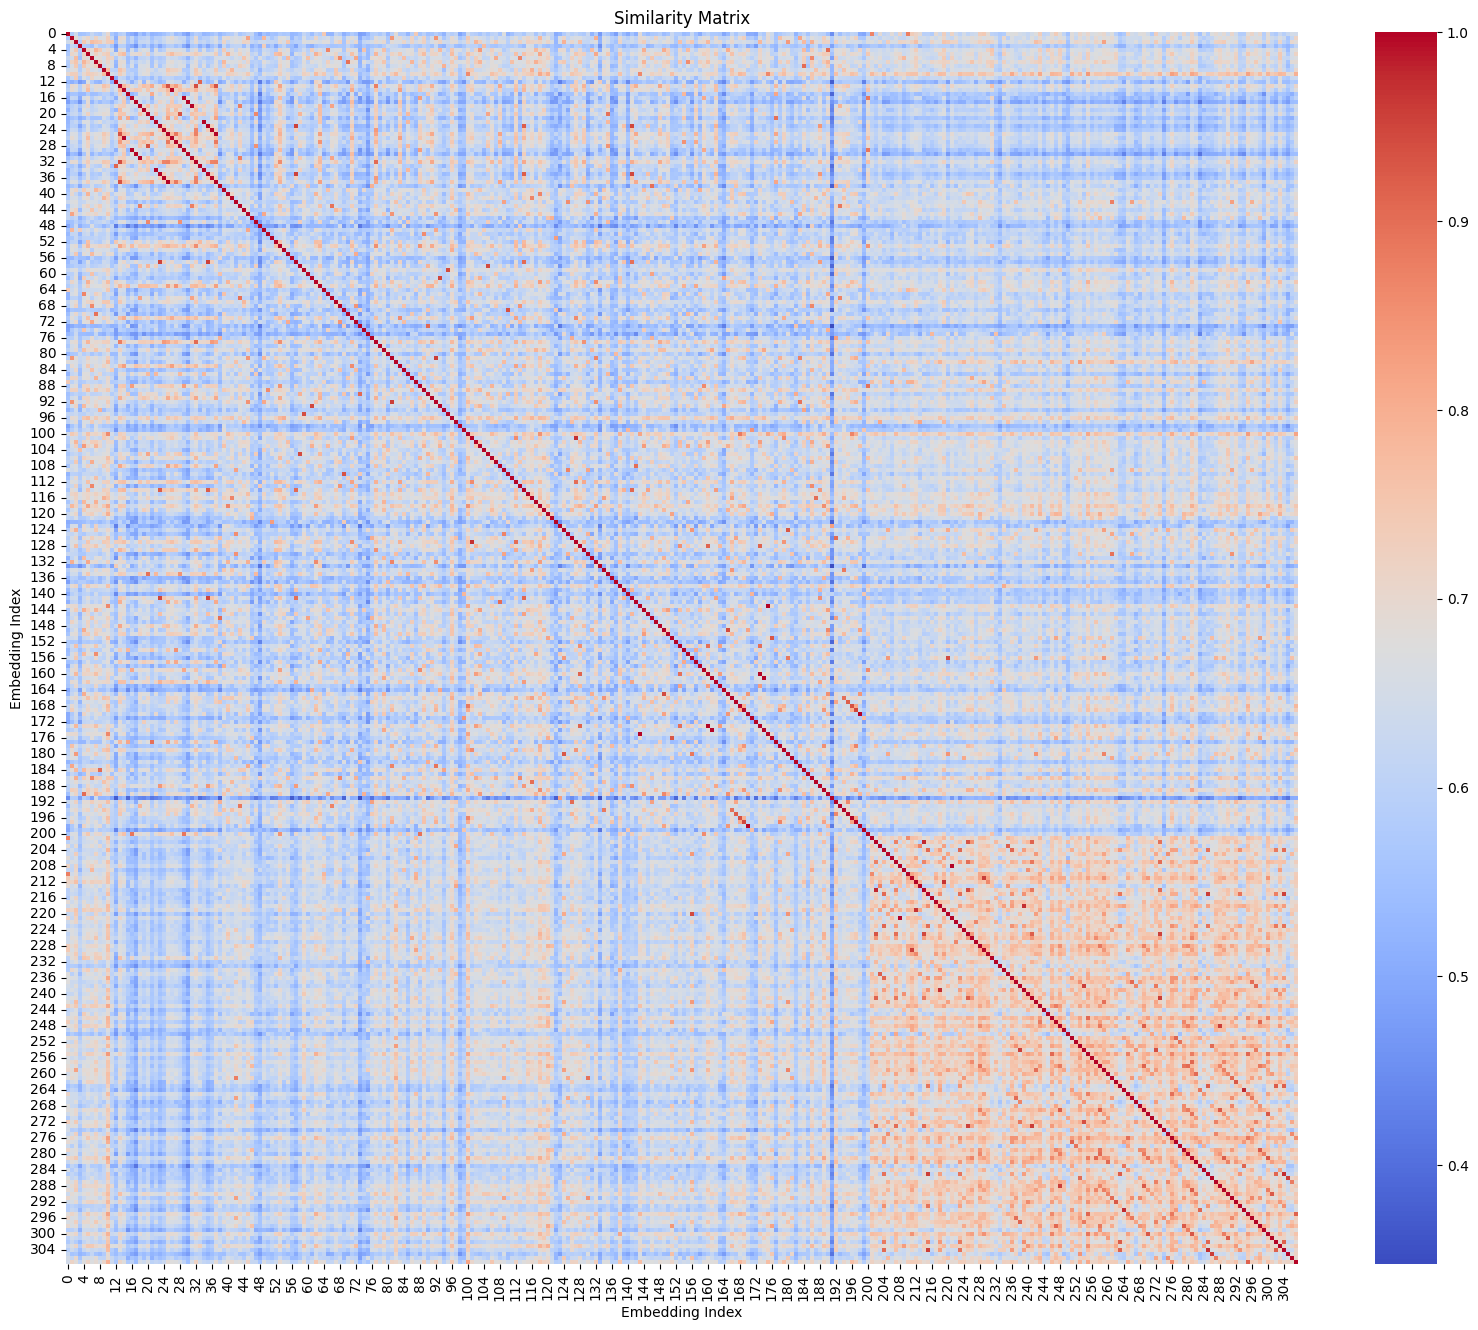

In [13]:
def visualize_similarity_matrix(matrix, title="Similarity Matrix"):
    plt.figure(figsize=(20, 16))
    sns.heatmap(matrix, annot=False, cmap='coolwarm', square=True)
    plt.title(title)
    plt.ylabel('Embedding Index')
    plt.xlabel('Embedding Index')
    plt.show()

# Assuming you have already created the similarity matrix
visualize_similarity_matrix(similarity_matrix)

In [14]:
def compare_single_embedding_to_others(single_embedding, embeddings):
    similarities = [np.dot(single_embedding,emb)/(norm(single_embedding)*norm(emb)) for emb in embeddings]
    return similarities

specific_text = "AI"
specific_embedding = llm.embed_query(specific_text)
similarities = compare_single_embedding_to_others(specific_embedding, embeddings)

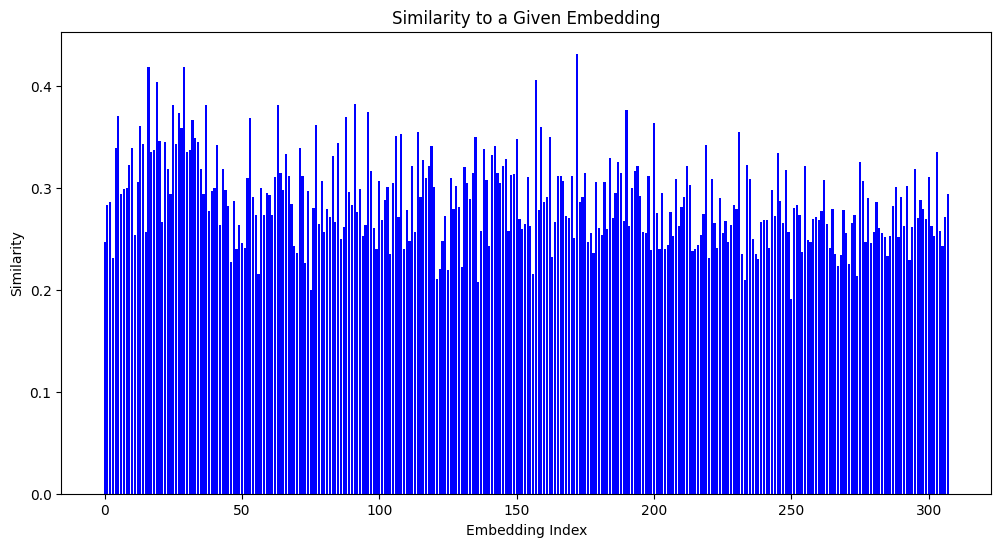

In [15]:
def visualize_embedding_similarity(similarities, title="Similarity to a Given Embedding"):
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(similarities)), similarities, color='blue')
    plt.xlabel('Embedding Index')
    plt.ylabel('Similarity')
    plt.title(title)
    plt.show()

visualize_embedding_similarity(similarities)

In [26]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def embed_specific_query(query):
    filtered_list = []
    for w in query:
        if w not in stop_words:
                filtered_list.append(w)
    filtered_query = " ".join(filtered_query)

    specific_embedding = llm.embed_query(query)
    return specific_embedding

def find_best_matches(input_embedding, embeddings, n=5):
    # Calculate cosine similarities (or any other similarity measure)
    similarities = [np.dot(input_embedding,emb)/(norm(input_embedding)*norm(emb)) for emb in embeddings]

    # Get the indexes of the top n matches
    best_match_indexes = sorted(range(len(similarities)), key=lambda i: similarities[i], reverse=True)[:n]

    return best_match_indexes, similarities

def get_best_match_rows(df, best_match_indexes):
    return df.iloc[best_match_indexes]

179

In [91]:
specific_text = "I want to learn how to rap and sing"
stream_model = llm_model(
    specific_text,
    max_tokens=512,
    grammar=grammar,
    stream=True,
)
for text in stream_model:
    print(text["choices"][0]["text"])

Llama.generate: prefix-match hit


{
 
 "
s
kil
ls
"
:
 "
rap
,
 singing
"
}



In [ ]:
# Assume you have an input embedding
specific_text = "I want to learn portuguese to prepare for my trip to Brazil"
specific_embedding = llm.embed_specific_query(specific_text)
input_embedding = specific_embedding

# Find best match indexes
best_matches, ordered_similarities = find_best_matches(input_embedding, embeddings, n=20)

# Get the corresponding rows from the DataFrame
best_match_rows = get_best_match_rows(df, best_matches)
best_match_rows